In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import os
import random
import pandas as pd

import pymc3 as pm
import exoplanet as xo
import theano.tensor as T

import caustic as ca

random.seed(42)

mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

# Print library version numbers
print("Numpy version", np.__version__)
print("PyMC3 version", pm.__version__)

%config InlineBackend.figure_format = 'retina'

Numpy version 1.13.0
PyMC3 version 3.7


# Load traces of all fitted events into memory

In [2]:
def load_samples(data_path, param_name):
    samples_list = []
    samples_logp_list = []
    
    for directory in os.listdir(data_path):
        # Load trace
        path = data_path + directory 
        try:
            trace = pd.read_csv(path + '/PSPL_hmc/trace.csv')
            samples_list.append(trace[param_name].values)
            samples_logp_list.append(trace['logp_' + param_name].values)
        except:
            pass
        
    return np.stack(samples_list, axis=0), np.stack(samples_logp_list, axis=0)

samples, logp_samples = load_samples('../output/2017/', 'ln_Delta_F__0')

Text(0.5, 0, 'median $\\Delta F$')

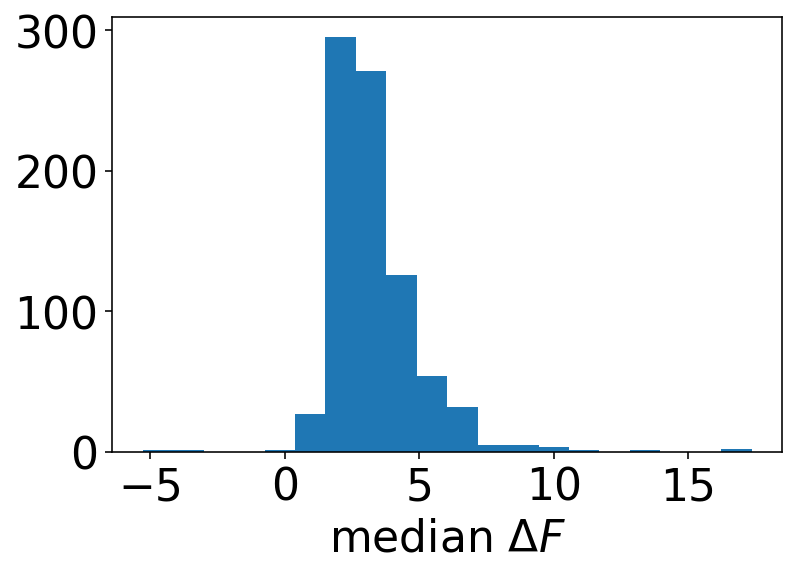

In [3]:
# Plot histograms 
fig, ax = plt.subplots()

ax.hist(np.median(samples, axis=1), bins=20);
ax.set_xlabel('median $\Delta F$')

In [4]:
# Remove any events with large variance for Delta_F
indices = []
for i, sample in enumerate(samples):
    if np.std(sample)/np.median(sample) > 0.5:
        indices.append(i)
indices

[19, 81, 172, 208, 308, 484, 733]

In [5]:
samples = np.delete(samples, indices, 0)
samples_logp = np.delete(logp_samples, indices, 0)

In [6]:
np.shape(samples)

(818, 4000)

In [7]:
np.shape(samples_logp)

(818, 4000)

# Fit hierarchical model

In [12]:
# Convert samples to theano.tensor
samples_tensor = T.as_tensor_variable(samples[::3, ::10]) # for performance reasons
samples_logp_tensor = T.as_tensor_variable(samples_logp[::3, ::10])

In [13]:
# This will take a while, loading the massive arrays into memory is costly
with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)

    # Parameters of the prior for Delta_F
    mu = pm.Normal('mu', 5., 20., testval=3.)
    sig = BoundedNormal('sig', 5., 20., testval=3.)
    
    def compute_ll():
        n_events = T.shape(samples_tensor).eval()[0]
                
        result = 0.

        # Iterate over members of the population
        for i in range(n_events):
            n_samples = T.shape(samples_tensor).eval()[1]

            # Compute new prior
            new_prior = T.exp(-0.5*(samples_tensor[i] - mu)**2/sig**2)/T.sqrt(2*np.pi*sig**2)
            
            # Compute importance resampling fraction
            frac = new_prior/T.exp(samples_logp_tensor[i])

            result += T.log(T.sum(frac)/n_samples)
                            
        return result                            
                            
    pm.Potential('log_likelihood', compute_ll())

In [14]:
with model:
    # Print initial logps
    initial_logps = [RV.logp(model.test_point) for RV in model.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace = pm.sample(tune=100, draws=500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Initial values of log priors: [array(-3.9196708067586634), array(-2.8210585180905534)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:45<00:00, 52.37draws/s]
The acceptance probability does not match the target. It is 0.919387459061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.943854448185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.931036030706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.920623273189, but should be close to 0.8. Try to increase the number of tuning steps.


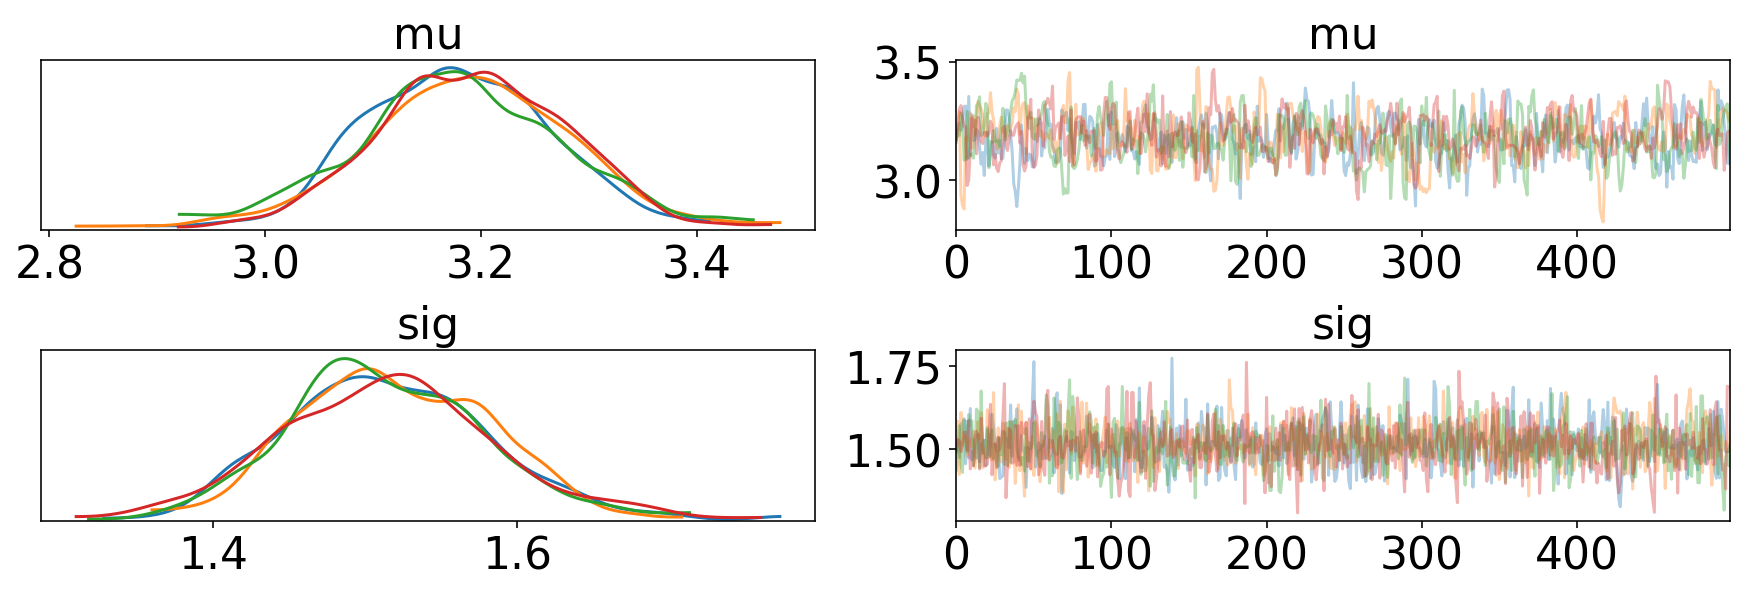

In [17]:
pm.traceplot(trace);

(-10, 20)

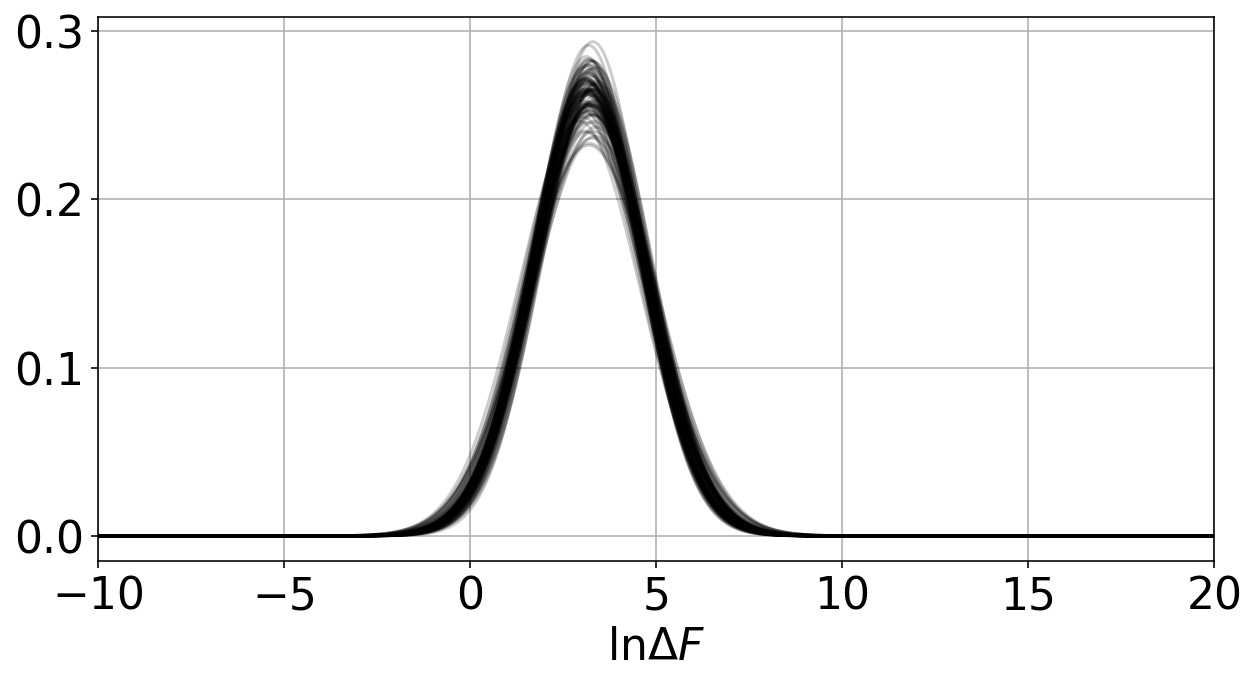

In [21]:
import scipy

fig, ax = plt.subplots(figsize=(10, 5))

samples_hyper = np.stack((trace['mu'], trace['sig'])).T


x = np.linspace(-10, 50., 5000)

for mu, sig in samples_hyper[np.random.randint(len(samples_hyper), size=100)]:
    plot = scipy.stats.norm.pdf(x, mu, sig)
    ax.plot(x, plot, color='black', alpha=0.2)

ax.grid()
ax.set_xlabel(r'$\ln\Delta F$')
ax.set_xlim(-10, 20)
# ax.set_ylim(0, 0.5)

In [22]:
# Save the samples to disk
np.save('samples_hyper.npy', samples_hyper)